# Advanced XGBoost Model with NLP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
import tensorflow_hub as hub
import xgboost as xgb

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score

from imblearn.over_sampling import RandomOverSampler

%matplotlib inline

Using TensorFlow backend.


In [2]:
def confusion_reporting(true_values, pred_values):
    '''
    This function takes in the true values of a dataset and the predicted values
    of the dataset and prints out a classification report, accuracy score, and
    plots the confusion matrix of the true and predicted values for simple analysis
    '''
    print(confusion_matrix(true_values, pred_values))
    print(classification_report(true_values, pred_values))
    print('Accuracy score:', round(accuracy_score(true_values, pred_values), 4))
    print('F1 score:', round(f1_score(true_values, pred_values), 4))

    cm = confusion_matrix(true_values, pred_values)
    df_cm = pd.DataFrame(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis],
                         index=['F', 'T'],
                         columns=['F', 'T'])
    plt.figure(figsize=(7, 5))
    sns.heatmap(df_cm, annot=True, cmap='Greens', vmin=0, vmax=1)
    plt.xlabel('Pred Val')
    plt.ylabel('True Val')
    plt.show()

In [3]:
main_df = pd.read_pickle('main_df.pkl')

display(main_df.head())
display(main_df.info())

,congress,chamber,rollnumber,icpsr,cast_code,state_abbrev,bioname,bioguide_id,born,nominate_dim1,...,cosponsor_my_party,cosponsors^2,cosponsors_D^2,cosponsors_R^2,cosponsors_ID^2,cosponsor_my_party^2,party_D,sponsor_party_D,party_R,sponsor_party_R
5,113,Senate,1,14009,1,MS,"COCHRAN, William Thad",C000567,1937,0.287,...,1,4.0,1,1,0,1,0,1,1,0
12,113,Senate,1,14203,1,MT,"BAUCUS, Max Sieben",B000243,1941,-0.212,...,1,4.0,1,1,0,1,1,1,0,0
18,113,Senate,1,14226,1,IA,"GRASSLEY, Charles Ernest",G000386,1933,0.346,...,1,4.0,1,1,0,1,0,1,1,0
24,113,Senate,1,14230,1,IA,"HARKIN, Thomas Richard (Tom)",H000206,1939,-0.351,...,1,4.0,1,1,0,1,1,1,0,0
30,113,Senate,1,14307,1,VT,"LEAHY, Patrick Joseph",L000174,1940,-0.361,...,1,4.0,1,1,0,1,1,1,0,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 102692 entries, 5 to 306260
Data columns (total 78 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   congress                       102692 non-null  int64  
 1   chamber                        102692 non-null  object 
 2   rollnumber                     102692 non-null  int64  
 3   icpsr                          102692 non-null  int64  
 4   cast_code                      102692 non-null  int64  
 5   state_abbrev                   102692 non-null  object 
 6   bioname                        102692 non-null  object 
 7   bioguide_id                    102692 non-null  object 
 8   born                           102692 non-null  int64  
 9   nominate_dim1                  102692 non-null  float64
 10  nominate_dim2                  102692 non-null  float64
 11  party                          102692 non-null  object 
 12  last_name                     

None

#### Drop all roll numbers excepts last for each bill

In [4]:
last_roll_per_bill = main_df.groupby(['congress', 'bill_number']).rollnumber.max().reset_index()
last_roll_per_bill.columns = ['congress', 'bill_number', 'last_rollcall']
main_df_last_roll = main_df.merge(last_roll_per_bill, how='left', on=['congress', 'bill_number'])

main_df = main_df_last_roll[main_df_last_roll['rollnumber'] == main_df_last_roll['last_rollcall']]

main_df = main_df.reset_index(drop=True)

display(main_df.head())
display(main_df.tail())
display(main_df.info())

,congress,chamber,rollnumber,icpsr,cast_code,state_abbrev,bioname,bioguide_id,born,nominate_dim1,...,cosponsors^2,cosponsors_D^2,cosponsors_R^2,cosponsors_ID^2,cosponsor_my_party^2,party_D,sponsor_party_D,party_R,sponsor_party_R,last_rollcall
0,113,Senate,1,14009,1,MS,"COCHRAN, William Thad",C000567,1937,0.287,...,4.0,1,1,0,1,0,1,1,0,1
1,113,Senate,1,14203,1,MT,"BAUCUS, Max Sieben",B000243,1941,-0.212,...,4.0,1,1,0,1,1,1,0,0,1
2,113,Senate,1,14226,1,IA,"GRASSLEY, Charles Ernest",G000386,1933,0.346,...,4.0,1,1,0,1,0,1,1,0,1
3,113,Senate,1,14230,1,IA,"HARKIN, Thomas Richard (Tom)",H000206,1939,-0.351,...,4.0,1,1,0,1,1,1,0,0,1
4,113,Senate,1,14307,1,VT,"LEAHY, Patrick Joseph",L000174,1940,-0.361,...,4.0,1,1,0,1,1,1,0,0,1


,congress,chamber,rollnumber,icpsr,cast_code,state_abbrev,bioname,bioguide_id,born,nominate_dim1,...,cosponsors^2,cosponsors_D^2,cosponsors_R^2,cosponsors_ID^2,cosponsor_my_party^2,party_D,sponsor_party_D,party_R,sponsor_party_R,last_rollcall
23221,116,Senate,508,49300,1,CA,"FEINSTEIN, Dianne",F000062,1933,-0.268,...,136161.0,40401,28224,0,40401,1,1,0,0,508
23222,116,Senate,508,49308,1,WA,"MURRAY, Patty",M001111,1950,-0.350,...,136161.0,40401,28224,0,40401,1,1,0,0,508
23223,116,Senate,508,49703,1,ME,"COLLINS, Susan Margaret",C001035,1952,0.112,...,136161.0,40401,28224,0,28224,0,1,1,0,508
23224,116,Senate,508,49706,1,WY,"ENZI, Michael B.",E000285,1944,0.544,...,136161.0,40401,28224,0,28224,0,1,1,0,508
23225,116,Senate,508,94659,1,AL,"SHELBY, Richard C.",S000320,1934,0.428,...,136161.0,40401,28224,0,28224,0,1,1,0,508


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23226 entries, 0 to 23225
Data columns (total 79 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   congress                       23226 non-null  int64  
 1   chamber                        23226 non-null  object 
 2   rollnumber                     23226 non-null  int64  
 3   icpsr                          23226 non-null  int64  
 4   cast_code                      23226 non-null  int64  
 5   state_abbrev                   23226 non-null  object 
 6   bioname                        23226 non-null  object 
 7   bioguide_id                    23226 non-null  object 
 8   born                           23226 non-null  int64  
 9   nominate_dim1                  23226 non-null  float64
 10  nominate_dim2                  23226 non-null  float64
 11  party                          23226 non-null  object 
 12  last_name                      23226 non-null 

None

## XGBoost - No summary, same features as Logit

In [5]:
dep_col = 'cast_code'
logit_features = pd.read_pickle("final_features.pkl")

In [6]:
scalar = StandardScaler()

y = main_df[dep_col]
X = main_df[logit_features['feature'].values]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train_sc = scalar.fit_transform(X_train)
X_test_sc = scalar.transform(X_test)

In [7]:
#Oversample training data
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X_train_sc, y_train)

In [8]:
# Define model
clf_xgb = xgb.sklearn.XGBClassifier(nthread=-1, seed=1234, 
                                    learning_rate =0.1,
                                    n_estimators=100,
                                    max_depth=5,
                                    min_child_weight=1,
                                    gamma=0,
                                    subsample=0.8,
                                    colsample_bytree=0.8,
                                    objective= 'binary:logistic',
                                    scale_pos_weight=1)

In [9]:
# Fit model
clf_xgb.fit(X_over, y_over)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=1234, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=1234, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
# Test accuracy on test data
predictions_xgb = clf_xgb.predict(X_test_sc)
# predictions_xgb = [item[1] for item in predictions_xgb]

[[1661  391]
 [ 852 4064]]
              precision    recall  f1-score   support

           0       0.66      0.81      0.73      2052
           1       0.91      0.83      0.87      4916

    accuracy                           0.82      6968
   macro avg       0.79      0.82      0.80      6968
weighted avg       0.84      0.82      0.83      6968

Accuracy score: 0.8216
F1 score: 0.8674


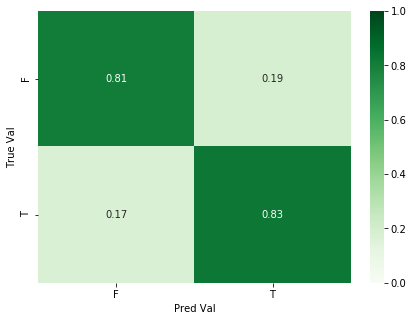

In [24]:
confusion_reporting(y_test, predictions_xgb)

In [25]:
ROC = roc_auc_score(y_test, predictions_xgb)
print("ROC_Test: %.2f%%" % (ROC * 100.0))

ROC_Test: 81.81%


### Define cols to use in model

#### A full list of features that could be used in model

In [32]:
# dep_col = 'cast_code'

# senator_info = ['nominate_dim1', 'nominate_dim2', 'percent_campaign_vote', 'election_year', 'tenure', 
#                 'age', 'is_sponsor', 'sponsor_is_same_party', 'party_D', 'party_R', 'cosponsor_my_party', 
#                 'cosponsor_my_party^2']

# bill_info = ['sponsor_party_is_lead', 'cosponsor_party_D_%', 'cosponsor_party_R_%', 
#              'percent_cosponsors_lead_party', 'lead_party_D', 'sponsor_party_D', 'sponsor_party_R',
#              'cosponsors', 'cosponsors_D', 'cosponsors_R', 'cosponsors_ID',
#              'cosponsors^2', 'cosponsors_D^2', 'cosponsors_R^2', 'cosponsors_ID^2']

# text_cols = ['summary']

# indep_cols = senator_info + bill_info + text_cols

#### Features used in logit model plus text features

In [26]:
dep_col = 'cast_code'

logit_features = list(pd.read_pickle('final_features.pkl')['feature'].values)

text_cols = ['summary']

indep_cols = logit_features + text_cols

In [27]:
scalar = StandardScaler()

y = main_df[dep_col]
X = main_df[indep_cols]

non_text_cols = [x for x in indep_cols if x not in text_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train_sc = scalar.fit_transform(X_train[non_text_cols])
X_test_sc = scalar.transform(X_test[non_text_cols])

X_train_df = pd.DataFrame(X_train_sc, index=y_train.index, columns=X[non_text_cols].columns).join(X_train[text_cols])
X_test_df = pd.DataFrame(X_test_sc, index=y_test.index, columns=X[non_text_cols].columns).join(X_test[text_cols])

In [28]:
unique_sum_train_df = pd.Series(X_train_df['summary'].unique())
unique_sum_test_df = pd.Series(X_test_df['summary'].unique())

In [30]:
X_train_df.head()

,sponsor_is_same_party,nominate_dim1,cosponsor_my_party,age,tenure,nominate_dim2,cosponsor_my_party^2,percent_campaign_vote,cosponsors^2,cosponsors,cosponsors_R^2,cosponsors_R,percent_cosponsors_lead_party,cosponsor_party_R_%,cosponsor_party_D_%,cosponsors_D,cosponsors_D^2,party_R,summary
16596,1.022268,0.779598,-0.424522,0.133386,-0.276504,0.953630,-0.207703,0.500759,-0.230616,-0.524426,-0.268546,-0.494335,-1.062691,-1.025518,-0.832516,-0.366198,-0.183841,1.019127,Establishes the congressional budget for the f...
7167,-0.978217,-1.011125,-0.324264,1.587519,2.051458,-0.240604,-0.205934,0.501934,-0.191652,-0.060287,-0.161669,0.209397,1.058352,1.103039,-0.473854,-0.272634,-0.182422,-0.981232,(This measure has not been amended since it wa...
9014,1.022268,1.145519,-0.424522,-1.805457,-0.609070,-0.765343,-0.207703,-1.060854,-0.230616,-0.524426,-0.268546,-0.494335,-1.062691,-1.025518,-0.832516,-0.366198,-0.183841,1.019127,"TITLE I--HEALTH, EDUCATION, LABOR, AND PENSION..."
9184,-0.978217,-0.853322,-0.424522,-0.545209,0.499483,-1.228562,-0.207703,0.297479,-0.230616,-0.524426,-0.268546,-0.494335,-1.062691,-1.025518,-0.832516,-0.366198,-0.183841,-0.981232,Every Student Succeeds Act TITLE I--IMPROVING ...
22256,-0.978217,-0.942515,-0.424522,0.715039,1.053760,0.200901,-0.207703,-0.664870,-0.230616,-0.524426,-0.268546,-0.494335,-1.062691,-1.025518,-0.832516,-0.366198,-0.183841,-0.981232,This resolution sets forth the rules governing...


### Text Vectorization

In [31]:
# Load cached model
module_path = 'universal-sentence-encoder_4'
embed = hub.load(module_path)

In [32]:
# Create embeddings 
X_train_embeddings = embed(unique_sum_train_df.values)
X_test_embeddings = embed(unique_sum_test_df.values)

In [33]:
X_train_embeddings

<tf.Tensor: shape=(245, 512), dtype=float32, numpy=
array([[ 0.03055005, -0.05715709,  0.00957497, ...,  0.01627482,
         0.04436757,  0.055716  ],
       [-0.00920579, -0.04992998, -0.04987555, ..., -0.04683334,
        -0.04994818, -0.04940972],
       [-0.05184007, -0.05204987, -0.02980429, ...,  0.05189972,
        -0.05062379,  0.04335627],
       ...,
       [-0.01197152, -0.07224006,  0.05763957, ...,  0.0503172 ,
         0.03344295,  0.00411961],
       [ 0.03292277, -0.01363321, -0.00461916, ...,  0.03332947,
        -0.04796211,  0.05001941],
       [-0.05092446, -0.05869472, -0.05279854, ..., -0.05145788,
        -0.05134519,  0.05795386]], dtype=float32)>

In [34]:
#turn the embeddings into dataframes to rejoin with the unique summaries
sum_cols = ['sum_'+str(i) for i in range(np.shape(X_train_embeddings)[1])]

vec_sum_train_df = unique_sum_train_df.to_frame(name='summary').join(pd.DataFrame(np.asarray(X_train_embeddings), 
                                                                                  columns=sum_cols))
vec_sum_test_df = unique_sum_test_df.to_frame(name='summary').join(pd.DataFrame(np.asarray(X_test_embeddings), 
                                                                                columns=sum_cols))

In [35]:
#merge the vectorized train and test dfs back onto the main train/test dfs, keeping original indexs
X_train_df['copy_index'] = X_train_df.index
X_test_df['copy_index'] = X_test_df.index

X_train_vec = X_train_df.merge(vec_sum_train_df, on='summary', how='left').set_index('copy_index')
X_test_vec = X_test_df.merge(vec_sum_test_df, on='summary', how='left').set_index('copy_index')

In [36]:
#Oversample training data
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
X_over_vec, y_over = oversample.fit_resample(X_train_vec, y_train)

In [37]:
X_over_vec

,sponsor_is_same_party,nominate_dim1,cosponsor_my_party,age,tenure,nominate_dim2,cosponsor_my_party^2,percent_campaign_vote,cosponsors^2,cosponsors,...,sum_502,sum_503,sum_504,sum_505,sum_506,sum_507,sum_508,sum_509,sum_510,sum_511
0,1.022268,0.779598,-0.424522,0.133386,-0.276504,0.953630,-0.207703,0.500759,-0.230616,-0.524426,...,-0.046663,-0.057215,0.056934,-0.048477,-0.056825,-0.044192,0.029186,0.016275,0.044368,0.055716
1,-0.978217,-1.011125,-0.324264,1.587519,2.051458,-0.240604,-0.205934,0.501934,-0.191652,-0.060287,...,-0.049925,-0.049950,0.049949,-0.046513,-0.049713,-0.042100,0.045080,-0.046833,-0.049948,-0.049410
2,1.022268,1.145519,-0.424522,-1.805457,-0.609070,-0.765343,-0.207703,-1.060854,-0.230616,-0.524426,...,-0.037379,-0.052050,0.043949,-0.052050,-0.037284,-0.051543,0.017755,0.051900,-0.050624,0.043356
3,-0.978217,-0.853322,-0.424522,-0.545209,0.499483,-1.228562,-0.207703,0.297479,-0.230616,-0.524426,...,-0.047637,-0.047637,-0.046169,0.045378,-0.047633,-0.047598,0.047636,-0.036919,-0.046090,0.047407
4,-0.978217,-0.942515,-0.424522,0.715039,1.053760,0.200901,-0.207703,-0.664870,-0.230616,-0.524426,...,-0.033681,0.033380,0.051329,0.025502,-0.025483,-0.057739,0.005372,0.024926,-0.009318,0.062118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23021,1.022268,1.923100,-0.391103,-1.417688,-0.165649,-1.253894,-0.207506,1.202251,-0.230543,-0.504246,...,0.030659,-0.063772,0.025134,0.052062,0.062615,-0.024750,-0.041347,0.006756,-0.008755,0.044338
23022,-0.978217,-1.564580,-0.257425,-1.320746,-0.719926,-0.566304,-0.202789,-0.244210,-0.220010,-0.282266,...,-0.056561,-0.060358,0.033973,-0.060344,-0.045447,-0.046662,-0.021669,-0.047557,-0.052373,0.012464
23023,1.022268,1.923100,3.385292,-1.805457,-0.609070,-1.253894,2.346685,0.430257,0.794982,1.856811,...,-0.046346,-0.046346,0.038991,-0.015588,-0.046346,-0.039623,0.035426,-0.046339,-0.046346,0.046345
23024,1.022268,0.893948,0.678319,-0.836035,-0.941636,-1.438457,0.006342,-1.415713,-0.129780,0.222233,...,0.021801,-0.075369,-0.017255,-0.075719,0.002670,-0.048925,0.060867,0.070203,-0.007810,0.071290


In [38]:
print(sum(y_over == 1))
print(sum(y_over == 0))

11513
11513


### Run Model

In [39]:
# Define pipeline
clf_xgb = xgb.sklearn.XGBClassifier(nthread=-1, seed=1234, 
                                    learning_rate =0.1,
                                    n_estimators=100,
                                    max_depth=5,
                                    min_child_weight=1,
                                    gamma=0,
                                    subsample=0.8,
                                    colsample_bytree=0.8,
                                    objective= 'binary:logistic',
                                    scale_pos_weight=1)

In [40]:
#define cols for training
model_cols = sum_cols

In [41]:
# Fit model
clf_xgb.fit(X_over_vec[model_cols], y_over)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, nthread=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=1234, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=1234, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [48]:
# Test accuracy on test data
predictions_xgb = clf_xgb.predict(X_test_vec[model_cols])
# predictions_xgb = [item[1] for item in predictions_xgb]

[[1653  399]
 [1963 2953]]
              precision    recall  f1-score   support

           0       0.46      0.81      0.58      2052
           1       0.88      0.60      0.71      4916

    accuracy                           0.66      6968
   macro avg       0.67      0.70      0.65      6968
weighted avg       0.76      0.66      0.68      6968

Accuracy score: 0.661
F1 score: 0.7143


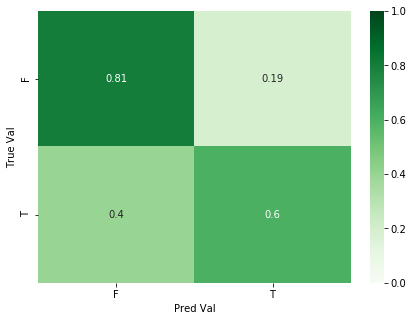

In [49]:
confusion_reporting(y_test, predictions_xgb)

In [50]:
ROC = roc_auc_score(y_test, predictions_xgb)
print("ROC_Test: %.2f%%" % (ROC * 100.0))

ROC_Test: 70.31%


# Working Zone

In [114]:
for i in range(1, len(non_text_cols)+1):
    model_cols = sum_cols + non_text_cols[:i]
    clf_xgb.fit(X_over_vec[model_cols], y_over)
    
    predictions_xgb = clf_xgb.predict_proba(X_test_vec[model_cols])
    predictions_xgb = [item[1] for item in predictions_xgb]
    
    ROC = roc_auc_score(y_test, predictions_xgb)
    print('Num cols beyond summary: ', i, 
          '\nLatest feature add: ', non_text_cols[i-1],
          "\nROC_Test: %.2f%%" % (ROC * 100.0), '\n')

Num cols beyond summary:  1 
Latest feature add:  nominate_dim1 
ROC_Test: 95.86% 

Num cols beyond summary:  2 
Latest feature add:  nominate_dim2 
ROC_Test: 95.88% 

Num cols beyond summary:  3 
Latest feature add:  percent_campaign_vote 
ROC_Test: 95.94% 

Num cols beyond summary:  4 
Latest feature add:  election_year 
ROC_Test: 95.81% 

Num cols beyond summary:  5 
Latest feature add:  tenure 
ROC_Test: 95.82% 

Num cols beyond summary:  6 
Latest feature add:  age 
ROC_Test: 95.97% 

Num cols beyond summary:  7 
Latest feature add:  is_sponsor 
ROC_Test: 95.78% 

Num cols beyond summary:  8 
Latest feature add:  sponsor_is_same_party 
ROC_Test: 96.84% 

Num cols beyond summary:  9 
Latest feature add:  party_D 
ROC_Test: 96.81% 

Num cols beyond summary:  10 
Latest feature add:  party_R 
ROC_Test: 96.81% 

Num cols beyond summary:  11 
Latest feature add:  cosponsor_my_party 
ROC_Test: 96.98% 

Num cols beyond summary:  12 
Latest feature add:  cosponsor_my_party^2 
ROC_Test: 96

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields summary